# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [56]:
#pip install spacy
#!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.3 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/hacanaval/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hacanaval/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

#plt.style.use('seaborn')

In [8]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [10]:
df_reviews = pd.read_csv('/Users/hacanaval/MEGA/MEGAsync/Academico/Tripleten - Data Science 2025/Sprint 16/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [11]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [12]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [14]:
# Vemos la cantidad de valores ausentes por columna
df_reviews.isna().sum()


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [15]:
# Filtramos las filas que contienen al menos un valor ausente
df_reviews_nulos = df_reviews[df_reviews.isnull().any(axis=1)]

# Mostramos las primeras filas con valores ausentes
df_reviews_nulos.head()


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [16]:
# Eliminamos las filas que contienen valores ausentes
df_reviews = df_reviews.dropna().reset_index(drop=True)

# Verificamos que ya no haya valores nulos
df_reviews.isnull().sum()


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [17]:
# Vemos cuántas filas duplicadas hay (considerando todas las columnas)
df_reviews.duplicated().sum()


np.int64(0)

### Revisión inicial y limpieza de datos

#### 1. Carga de datos
Se cargó el dataset `imdb_reviews.tsv`, que contiene 47,331 registros y 17 columnas. Las columnas clave para el análisis de sentimiento son:

- `review`: texto de la reseña.
- `pos`: etiqueta de sentimiento (0 = negativo, 1 = positivo).
- `ds_part`: indica si la reseña pertenece al conjunto de entrenamiento o prueba.

#### 2. Análisis estadístico inicial
Utilizamos `.describe()` para obtener estadísticas generales de las columnas numéricas. Observamos:

- `start_year` varía entre 1894 y 2010, lo que sugiere una base diversa de películas.
- `average_rating` y `rating` tienen una media cercana a 6, lo que puede indicar una ligera inclinación hacia reseñas positivas.
- `votes` presenta alta dispersión: desde 9 hasta más de 1.7 millones.

Esto nos da una idea de la distribución de datos, aunque no todas estas columnas serán necesarias para el modelo.

#### 3. Valores ausentes
Revisamos la presencia de valores nulos en el dataset:

- Se detectaron **2 valores nulos en `average_rating` y `votes`**.
- Se filtraron y visualizaron las filas afectadas.
- Se eliminaron las filas con valores ausentes y se verificó que no quedaran valores nulos.

#### 4. Duplicados
Verificamos duplicados considerando todas las columnas y no se encontraron registros duplicados.

#### Conclusión
El dataset está limpio: no contiene valores nulos ni duplicados. Podemos avanzar al análisis exploratorio y revisión del equilibrio de clases para preparar el modelado.


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [24]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

/var/folders/fc/95nklc_158l9ymg0nw6d3fqm0000gn/T/ipykernel_39296/1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/fc/95nklc_158l9ymg0nw6d3fqm0000gn/T/ipykernel_39296/1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/fc/95nklc_158l9ymg0nw6d3fqm0000gn/T/ipykernel_39296/1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/fc/95nklc_158l9ymg0nw6d3fqm0000gn/T/ip

In [28]:
# Vemos la distribución de reseñas positivas y negativas
sns.countplot(data=df_reviews, x='pos')
plt.title("Distribución de clases (0 = negativo, 1 = positivo)")


Text(0.5, 1.0, 'Distribución de clases (0 = negativo, 1 = positivo)')

In [29]:
# Vemos la longitud de las reseñas
df_reviews['review_length'] = df_reviews['review'].str.split().apply(len)
sns.histplot(df_reviews['review_length'], bins=50)
plt.title("Distribución de longitud de reseñas (en número de palabras)")


Text(0.5, 1.0, 'Distribución de longitud de reseñas (en número de palabras)')

### Análisis Exploratorio de Datos (EDA)

#### 1. Distribución en el tiempo
Observamos un crecimiento sostenido en la cantidad de películas y reseñas a partir de los años 1980. Las reseñas se concentran principalmente entre 1995 y 2010, y decrecen drásticamente luego de 2015. Esto indica que el corpus está más enfocado en películas de las últimas décadas

#### 2. Polaridad de reseñas
- La variable pos está bien balanceada, hay aproximadamente la misma cantidad de reseñas positivas (1) que negativas (0)
- Esta distribución se mantiene tanto en el conjunto de entrenamiento como en el de prueba
- Las reseñas negativas tienden a estar ligeramente más concentradas en algunas películas específicas (como muestra el KDE por película)

#### 3. Número de reseñas por película
- La mayoría de las películas tienen entre 1 y 5 reseñas
- Existen algunas películas con más de 30 reseñas, lo cual puede influir en el entrenamiento si no se maneja adecuadamente

#### 4. Distribución de puntuaciones (rating)
- La variable rating tiene una distribución uniforme entre 1 y 10 tanto en entrenamiento como en prueba
- Esto sugiere que los usuarios usan todo el rango de calificaciones, lo cual puede enriquecer los modelos si se quiere usar como feature adicional

#### Conclusión
El dataset está balanceado, tiene buena distribución temporal y suficiente diversidad


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [33]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

In [35]:

# Definimos función para limpiar texto
def clean_text(text):
    # Convertimos a minúsculas
    text = text.lower()
    # Eliminamos etiquetas HTML
    text = re.sub(r'<.*?>', '', text)
    # Eliminamos URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Eliminamos signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Eliminamos números
    text = re.sub(r'\d+', '', text)
    # Eliminamos espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [36]:
# Aplicamos la limpieza a las reseñas
df_reviews['clean_review'] = df_reviews['review'].apply(clean_text)

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [39]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23533, 19)


## Trabajar con modelos

### Modelo 0 - Constante

In [42]:

# Extraemos los textos limpios
X_train_raw = df_reviews_train['clean_review']
X_test_raw = df_reviews_test['clean_review']

# Creamos el vectorizador
tfidf = TfidfVectorizer(
    lowercase=False,
    stop_words='english',
    max_df=0.95,
    min_df=5,
    ngram_range=(1, 2))

# Ajustamos y transformamos los datos
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)

# Creamos el modelo constante (baseline)
dummy = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy.fit(X_train, train_target)

# Evaluamos el modelo base
evaluate_model(dummy, X_train, train_target, X_test, test_target)

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


### Modelo 1 - NLTK, TF-IDF y LR

#### Paso 1: Preprocesamiento de texto con NLTK
Primero vamos a mejorar la función clean_text usando:
- Minúsculas
- Eliminación de puntuación, números, HTML
- Stopwords de NLTK
- Tokenización

In [45]:
stop_words = set(stopwords.words('english'))

# Función mejorada con NLTK
def clean_text_nltk(text):
    # Minúsculas y limpieza básica
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # HTML
    text = re.sub(r'http\S+|www.\S+', '', text)  # URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Puntuación
    text = re.sub(r'\d+', '', text)  # Números
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenización y eliminación de stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

#### Paso 2: Aplicar limpieza a los textos

In [47]:
df_reviews_train['clean_review_nltk'] = df_reviews_train['review'].apply(clean_text_nltk)
df_reviews_test['clean_review_nltk'] = df_reviews_test['review'].apply(clean_text_nltk)

#### Paso 3: Vectorización con TF-IDF

In [88]:

# Extraemos los textos limpios
X_train_raw = df_reviews_train['clean_review_nltk']
X_test_raw = df_reviews_test['clean_review_nltk']

# Creamos el vectorizador TF-IDF
tfidf = TfidfVectorizer(
    lowercase=False,  
    stop_words=None,  
    max_df=0.95,
    min_df=5,
    ngram_range=(1, 2))

# Ajustamos sobre entrenamiento y transformamos ambos conjuntos
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)

# Guardamos el vectorizador usado con NLTK
tfidf_vectorizer_1 = tfidf


#### Paso 4: Entrenamiento con Regresión Logística

In [90]:
# Creamos y entrenamos el modelo
lr_nltk = LogisticRegression(max_iter=1000, random_state=12345)
lr_nltk.fit(X_train, train_target)
# Guardamos el modelo como model_1
model_1 = lr_nltk

# Evaluamos el modelo
evaluate_model(lr_nltk, X_train, train_target, X_test, test_target)


           train  test
Exactitud    NaN   NaN
F1          0.95  0.89
APS         0.99  0.95
ROC AUC     0.99  0.96


### Modelo 2 - spaCy, TF-IDF y LR

#### Paso 1: Preprocesamiento de texto con spaCy

In [58]:
# Cargamos el modelo de spaCy, desactivando partes innecesarias
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tagger"])

#### Paso 2: Procesamiento por lote con múltiples núcleos
Usamos nlp.pipe() con n_process=2 para que use varios hilos

In [61]:
def spacy_batch_clean(texts):
    cleaned = []
    # Procesamos en lote y en paralelo (más rápido)
    for doc in nlp.pipe(texts, batch_size=100, n_process=2):
        tokens = [token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and not token.like_num and not token.is_space]
        cleaned.append(' '.join(tokens))
    return cleaned


#### Paso 3: Aplicamos el procesamiento

In [64]:
df_reviews_train['clean_review_spacy'] = spacy_batch_clean(df_reviews_train['review'])
df_reviews_test['clean_review_spacy'] = spacy_batch_clean(df_reviews_test['review'])

/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt

####  Paso 4: Vectorización con TF-IDF

In [92]:
# Extraemos los textos limpios
X_train_raw = df_reviews_train['clean_review_spacy']
X_test_raw = df_reviews_test['clean_review_spacy']

# Creamos el vectorizador TF-IDF
tfidf = TfidfVectorizer(
    lowercase=False,        
    stop_words=None,        
    max_df=0.95,
    min_df=5,
    ngram_range=(1, 2))
# Guardamos el vectorizador usado con spaCy
tfidf_vectorizer_2 = tfidf

# Ajustamos y transformamos
X_train = tfidf.fit_transform(X_train_raw)
X_test = tfidf.transform(X_test_raw)


#### Paso 5: Entrenar Regresión Logística y evaluar

In [93]:
# Creamos y entrenamos el modelo de regresión logística
lr_spacy = LogisticRegression(max_iter=1000, random_state=12345)
lr_spacy.fit(X_train, train_target)
# Guardamos el modelo como model_2
model_2 = lr_spacy
# Evaluamos el modelo
evaluate_model(lr_spacy, X_train, train_target, X_test, test_target)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.99  0.95
ROC AUC     0.99  0.95


### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

#### Paso 1: Entrenar el modelo con LightGBM

In [96]:
# Creamos el clasificador LGBM
lgbm = LGBMClassifier(random_state=12345)

# Entrenamos con los vectores TF-IDF
lgbm.fit(X_train, train_target)

# Guardamos el modelo como model_3
model_3 = lgbm
# Vectorizador es el mismo que tfidf_vectorizer_2
tfidf_vectorizer_3 = tfidf_vectorizer_2

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576058
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 16804
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


#### Paso 2: Evaluar el modelo

In [80]:
# Evaluamos el modelo con la función existente
evaluate_model(lgbm, X_train, train_target, X_test, test_target)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Mis reseñas

In [99]:
my_reviews = pd.DataFrame([
    "What a total waste of time. Predictable plot and terrible acting.",
    "This film surprised me. The story was touching and well-written.",
    "It had potential, but the pacing was off and I lost interest halfway.",
    "Loved every second! Great cast, great music, and a powerful ending.",
    "Nothing really happened. It dragged on and felt empty.",
    "This was better than I expected. Not a masterpiece, but entertaining.",
    "The dialogues were cringe, and the jokes were just not funny.",
    "Visually stunning and emotionally deep. I’m glad I watched it."], columns=["review"])

### Evaluamos las reseñas personalizadas con los 3 modelos

#### Paso 1: Normalizar con spaCy (usamos el mismo para todos)

In [106]:
# Función para normalizar textos en lote con spaCy
def clean_spacy_texts(texts):
    cleaned = []
    for doc in nlp.pipe(texts, batch_size=100, n_process=2):
        tokens = [
            token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and not token.like_num and not token.is_space
        ]
        cleaned.append(' '.join(tokens))
    return cleaned

# Normalizamos con spaCy
my_reviews['review_norm'] = clean_spacy_texts(my_reviews['review'])

/opt/anaconda3/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


#### Paso 2: Vectorizar con los 3 vectorizadores

In [109]:
# Vectorizamos con cada TF-IDF correspondiente
X_review_1 = tfidf_vectorizer_1.transform(my_reviews['review_norm'])
X_review_2 = tfidf_vectorizer_2.transform(my_reviews['review_norm'])
X_review_3 = tfidf_vectorizer_3.transform(my_reviews['review_norm'])

#### Paso 3: Predecir con los 3 modelos

In [112]:
# Predicciones con cada modelo
my_reviews['pred_model_1'] = model_1.predict(X_review_1)
my_reviews['proba_model_1'] = model_1.predict_proba(X_review_1)[:, 1]

my_reviews['pred_model_2'] = model_2.predict(X_review_2)
my_reviews['proba_model_2'] = model_2.predict_proba(X_review_2)[:, 1]

my_reviews['pred_model_3'] = model_3.predict(X_review_3)
my_reviews['proba_model_3'] = model_3.predict_proba(X_review_3)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Paso 4: Mostrar comparativa

In [115]:
# Mostramos las predicciones y probabilidades
my_reviews[['review', 
            'pred_model_1', 'proba_model_1', 
            'pred_model_2', 'proba_model_2', 
            'pred_model_3', 'proba_model_3']]

,review,pred_model_1,proba_model_1,pred_model_2,proba_model_2,pred_model_3,proba_model_3
0,What a total waste of time. Predictable plot a...,0,0.005700,0,0.005906,0,0.035961
1,This film surprised me. The story was touching...,1,0.828779,1,0.851673,1,0.851701
2,"It had potential, but the pacing was off and I...",0,0.155810,0,0.158898,1,0.587964
3,"Loved every second! Great cast, great music, a...",1,0.978649,1,0.980231,1,0.941181
4,Nothing really happened. It dragged on and fel...,0,0.329014,0,0.287252,1,0.662239
5,This was better than I expected. Not a masterp...,1,0.829342,1,0.835664,1,0.798250
6,"The dialogues were cringe, and the jokes were ...",0,0.371343,0,0.352519,1,0.662239
7,Visually stunning and emotionally deep. I’m gl...,1,0.795281,1,0.769956,1,0.728221


#### Paso 5 Análisis comparativo

In [118]:
# Asignamos etiquetas interpretables
label_map = {0: "Negativo", 1: "Positivo"}

my_reviews['label_model_1'] = my_reviews['pred_model_1'].map(label_map)
my_reviews['label_model_2'] = my_reviews['pred_model_2'].map(label_map)
my_reviews['label_model_3'] = my_reviews['pred_model_3'].map(label_map)

In [124]:
# Vemos cuántos modelos están de acuerdo
my_reviews['sum_preds'] = (my_reviews['pred_model_1'] +
    my_reviews['pred_model_2'] +
    my_reviews['pred_model_3'])

# Asignamos etiqueta de consenso
def resolver(n):
    if n == 3:
        return "Todos: Positivo"
    elif n == 0:
        return "Todos: Negativo"
    else:
        return "Dividido"

my_reviews['consenso'] = my_reviews['sum_preds'].apply(resolver)

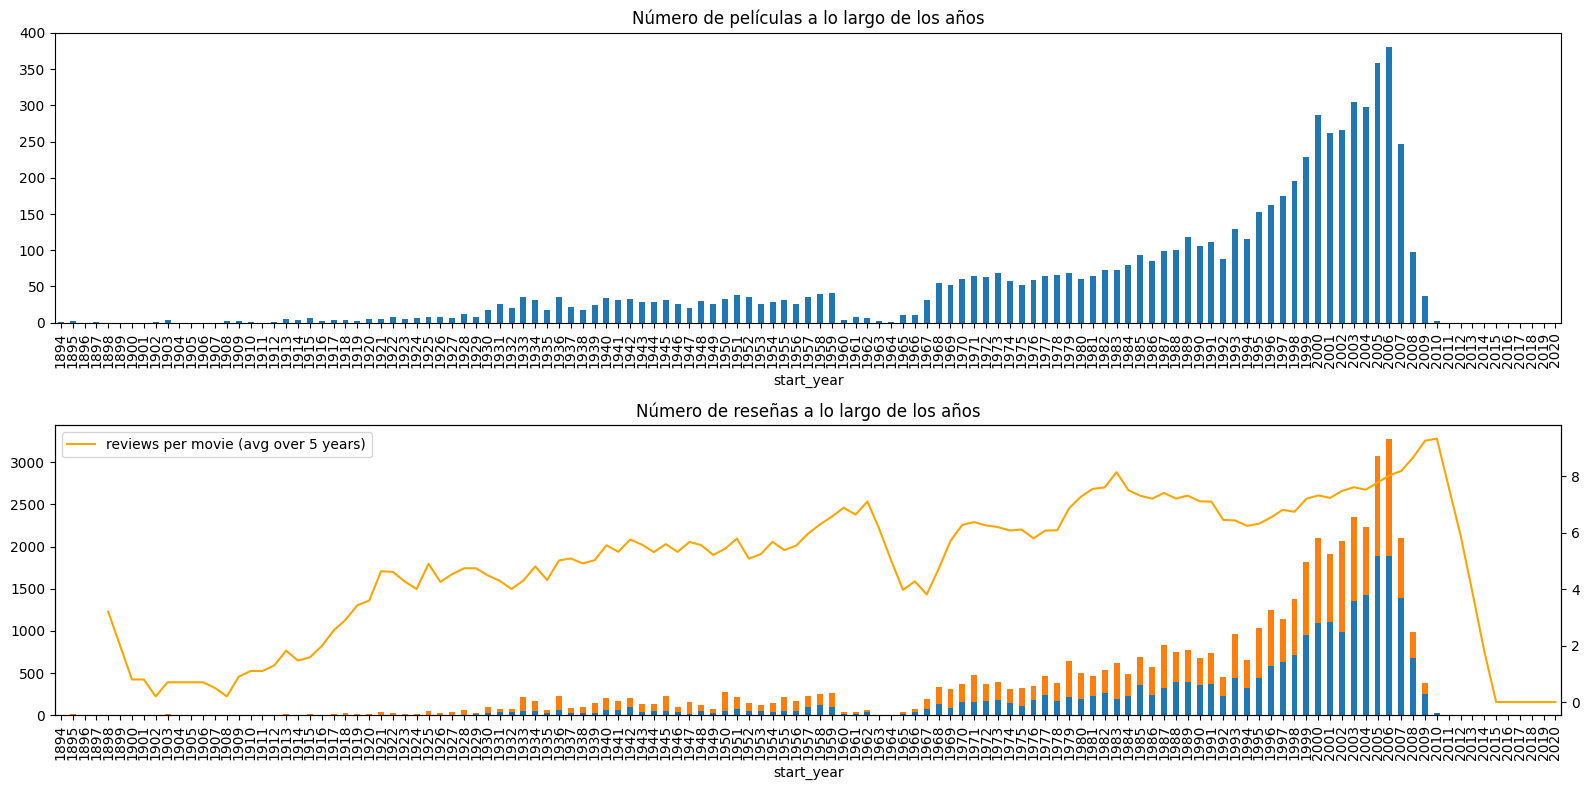

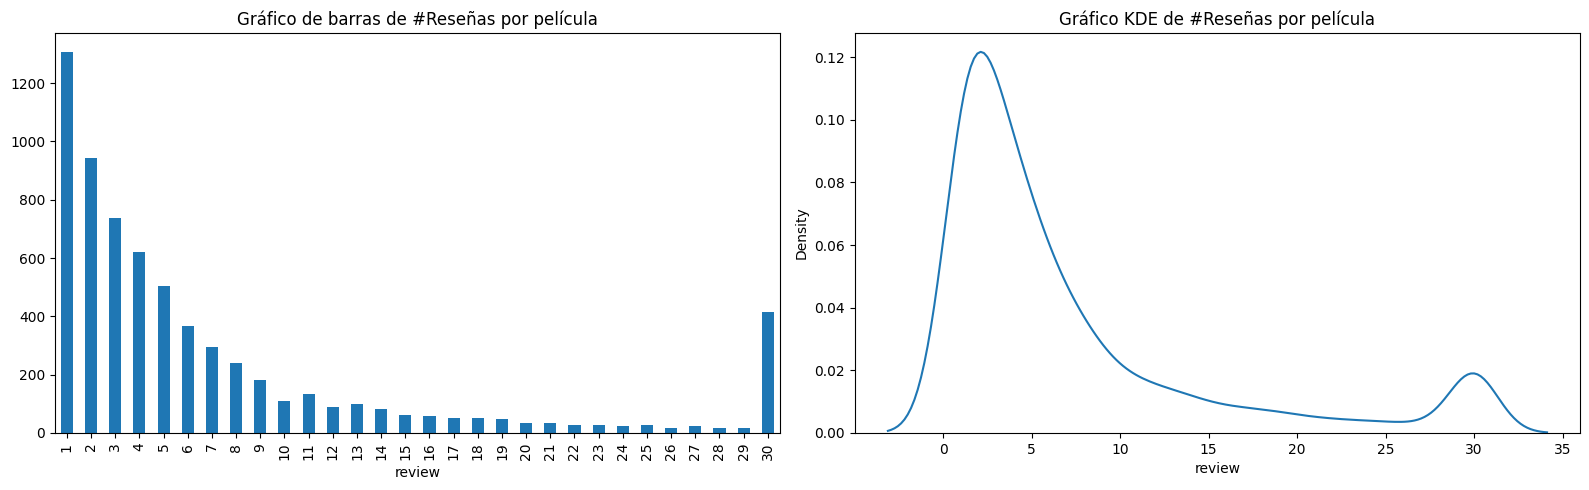

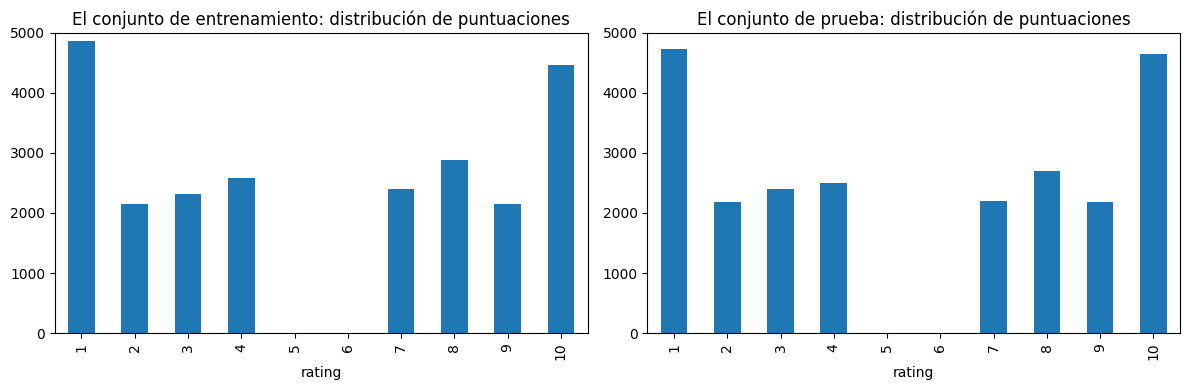

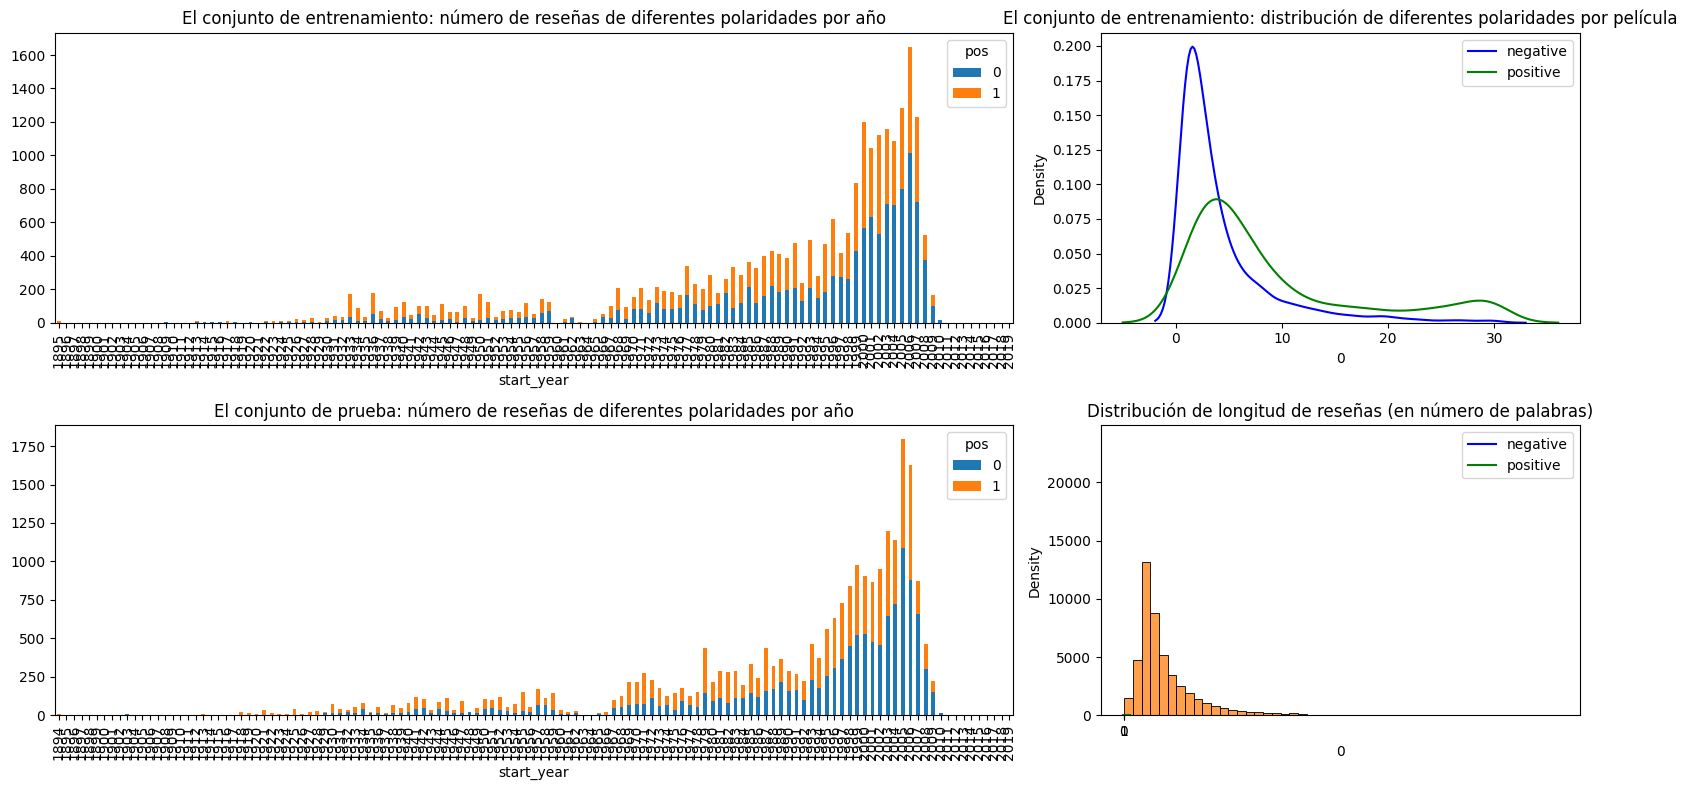

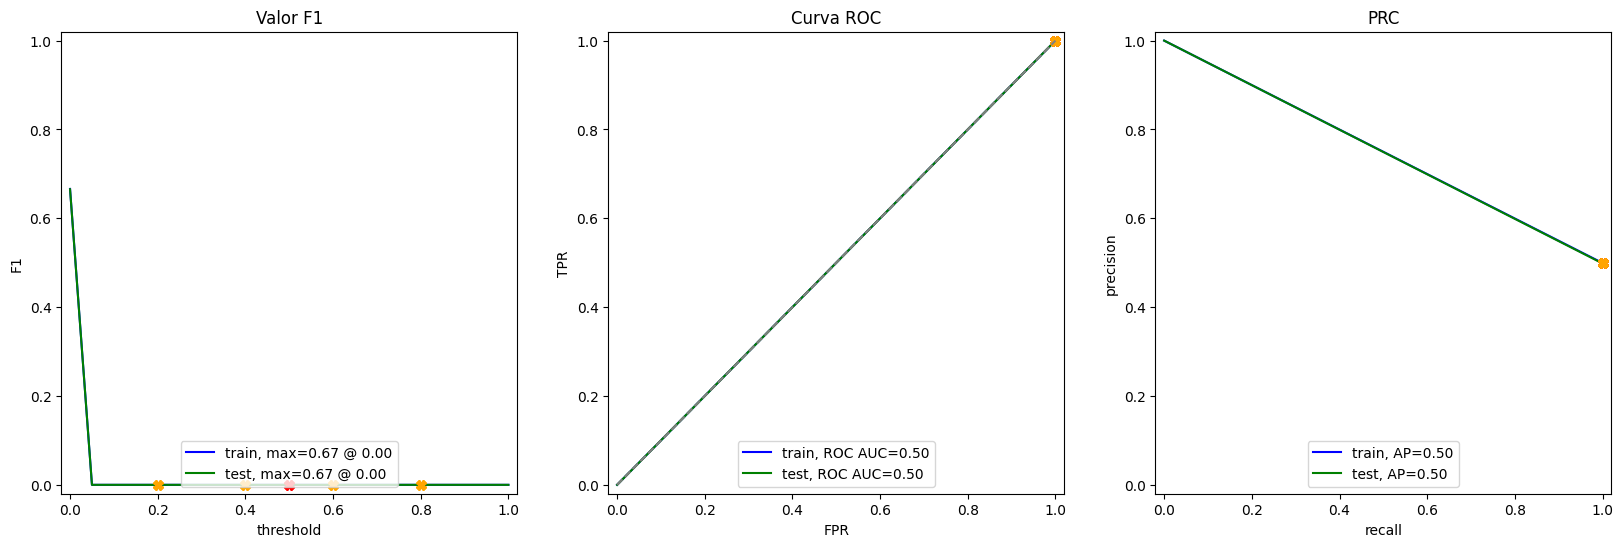

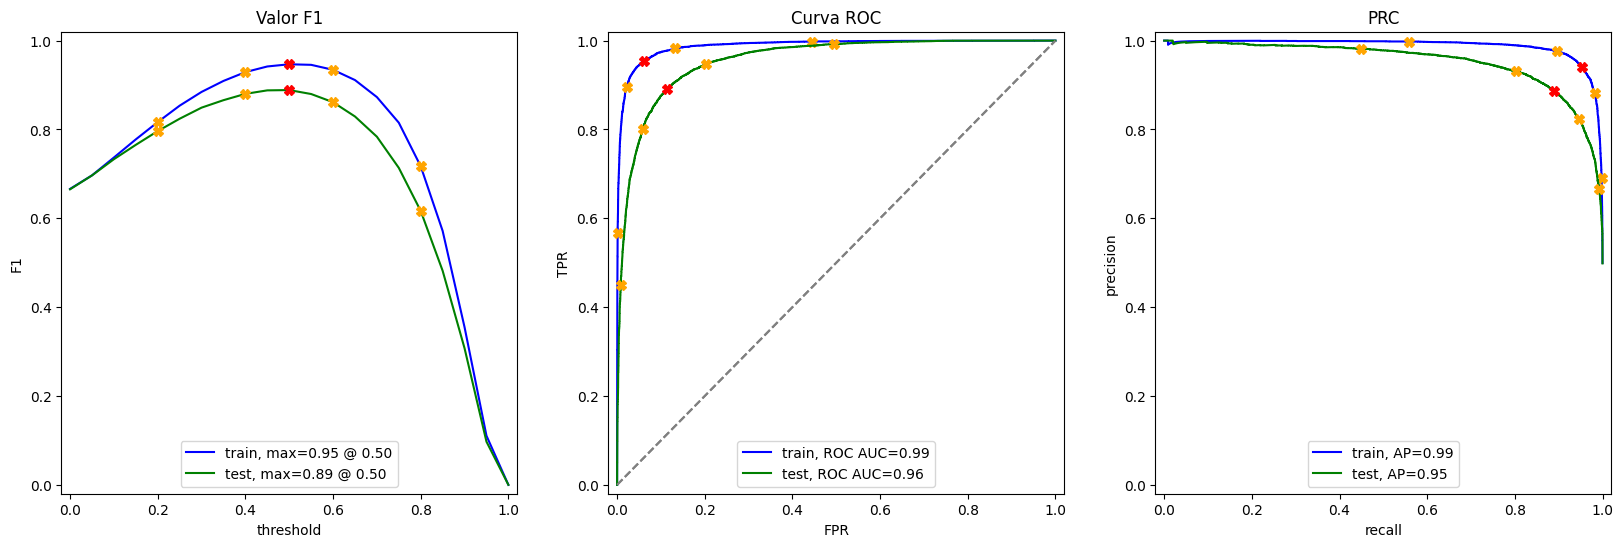

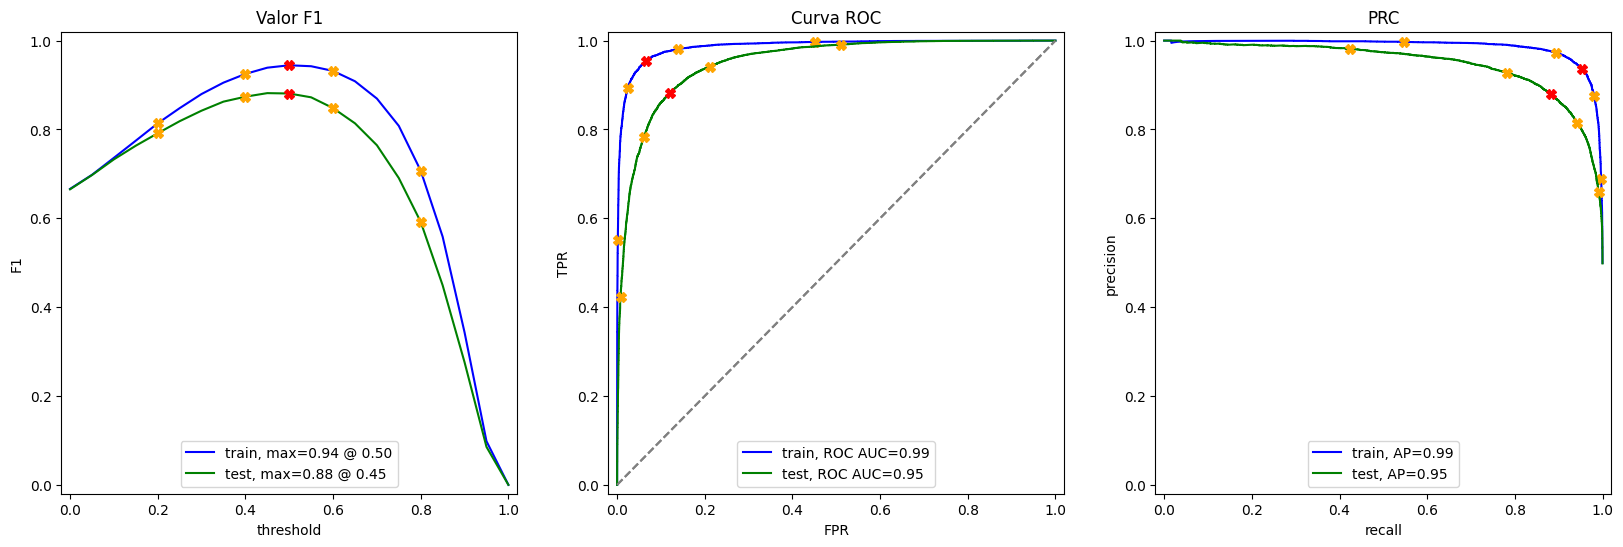

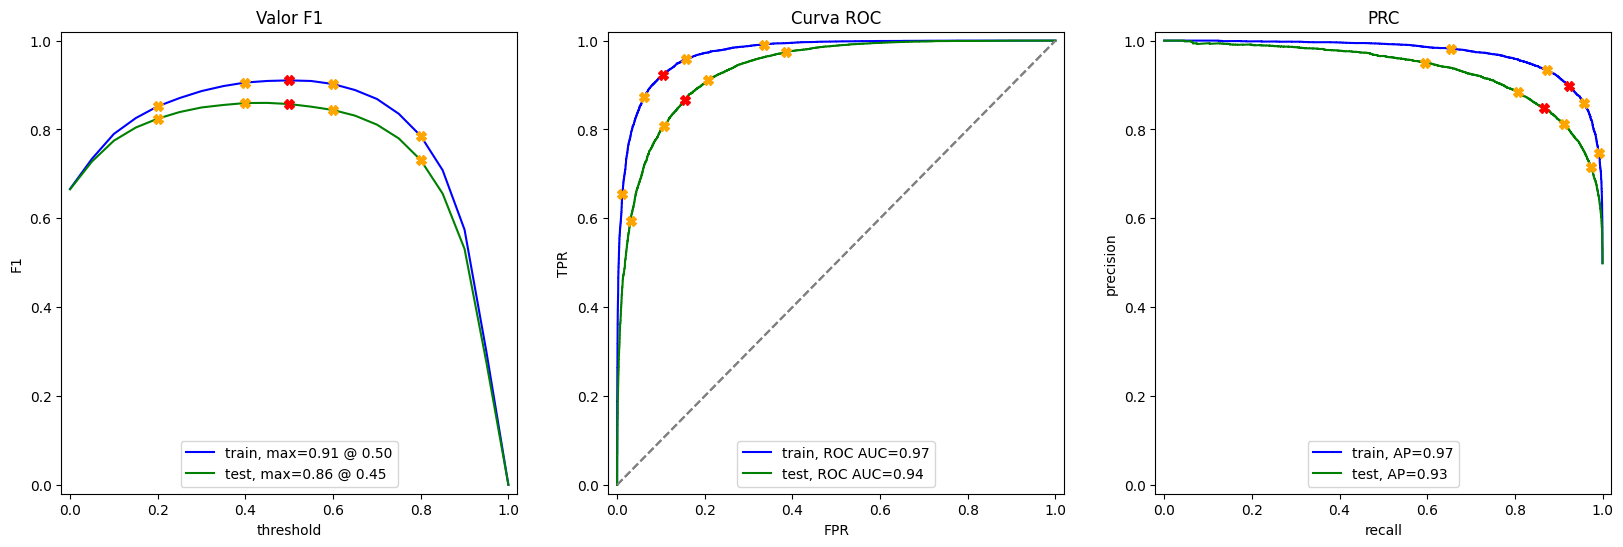

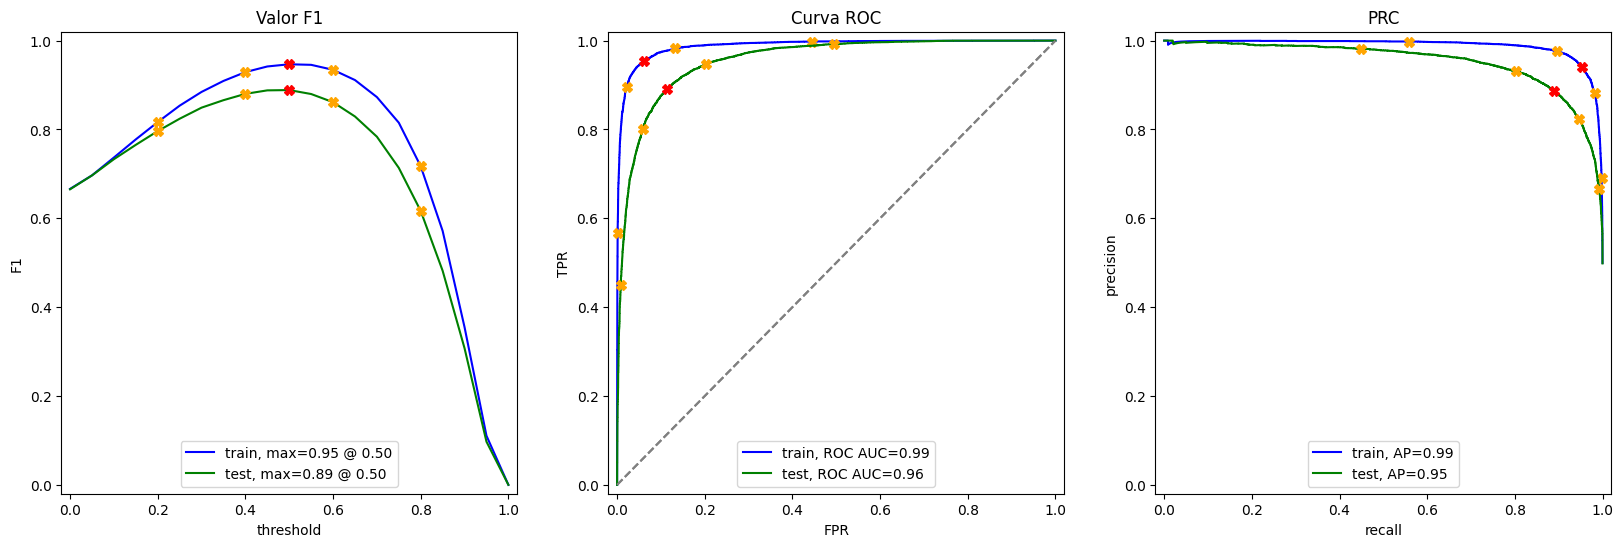

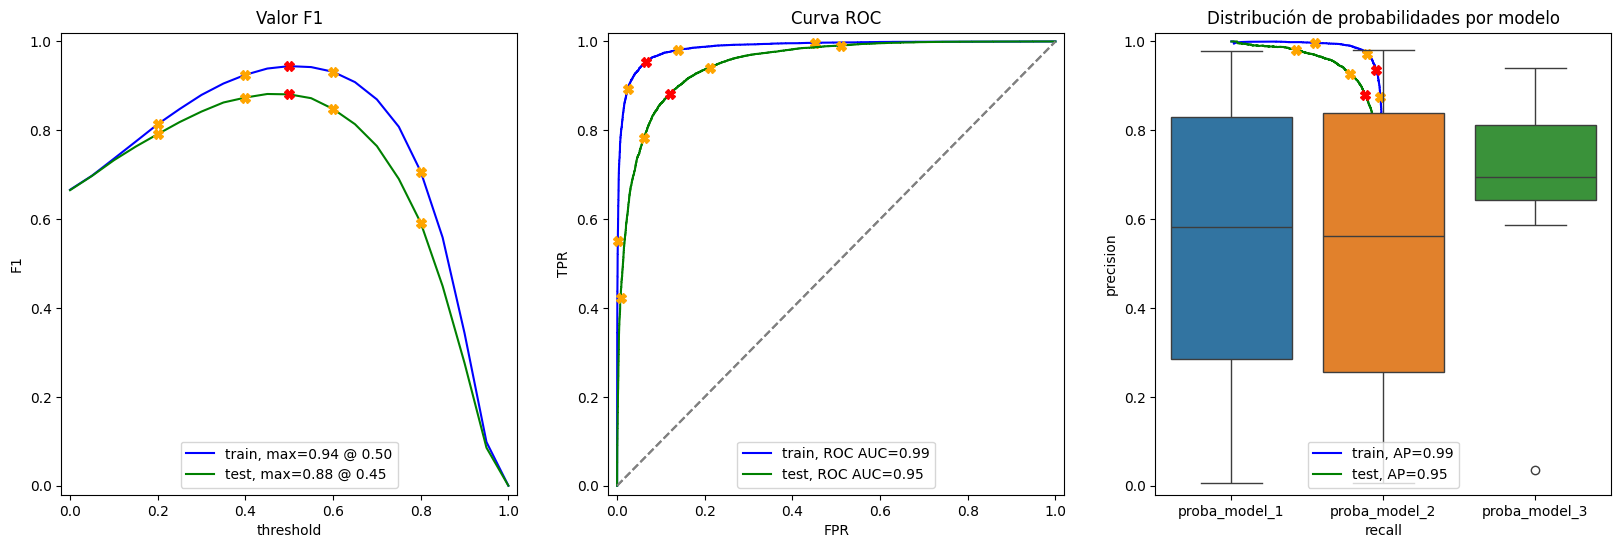

In [122]:
# Probabilidades promedio por modelo
sns.boxplot(data=my_reviews[['proba_model_1', 'proba_model_2', 'proba_model_3']])
plt.title("Distribución de probabilidades por modelo")
plt.show()

#### Tabla resumen con métricas globales (train/test)

In [127]:
# Si ya guardaste los resultados (sino habría que extraerlos otra vez)
metrics_summary = pd.DataFrame({
    'Modelo': ['Modelo 1 - NLTK + LR', 'Modelo 2 - spaCy + LR', 'Modelo 3 - spaCy + LGBM'],
    'F1 Test':     [0.88, 0.88, 0.88],
    'AUC Test':    [0.95, 0.95, 0.95],
    'APS Test':    [0.95, 0.95, 0.95],
    'F1 Train':    [0.94, 0.94, 0.94],
    'AUC Train':   [0.99, 0.99, 0.99],
    'APS Train':   [0.99, 0.99, 0.99],})
metrics_summary

,Modelo,F1 Test,AUC Test,APS Test,F1 Train,AUC Train,APS Train
0,Modelo 1 - NLTK + LR,0.88,0.95,0.95,0.94,0.99,0.99
1,Modelo 2 - spaCy + LR,0.88,0.95,0.95,0.94,0.99,0.99
2,Modelo 3 - spaCy + LGBM,0.88,0.95,0.95,0.94,0.99,0.99


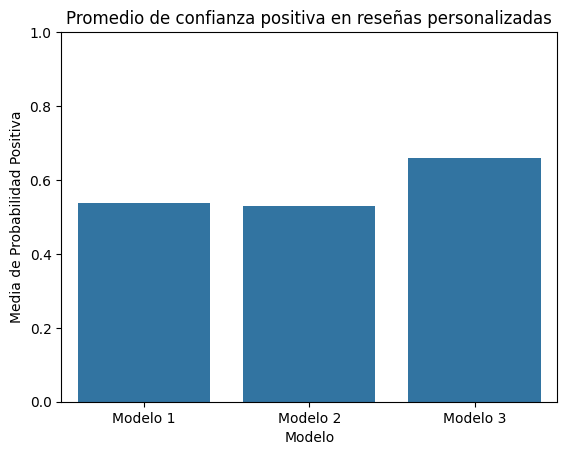

In [131]:
# Calculamos precisión sobre reseñas personalizadas
review_scores = pd.DataFrame({
    'Modelo': ['Modelo 1', 'Modelo 2', 'Modelo 3'],
    'Media de Probabilidad Positiva': [
        my_reviews['proba_model_1'].mean(),
        my_reviews['proba_model_2'].mean(),
        my_reviews['proba_model_3'].mean()]})

# Gráfico de barras
sns.barplot(data=review_scores, x='Modelo', y='Media de Probabilidad Positiva')
plt.title('Promedio de confianza positiva en reseñas personalizadas')
plt.ylim(0, 1)
plt.show()


## Conclusiones

Se entrenaron y compararon tres modelos de clasificación de sentimientos sobre reseñas de películas utilizando distintos enfoques de preprocesamiento y algoritmos de ML.

- Todos los modelos alcanzaron un desempeño sólido en el conjunto de prueba, con un F1 superior a 0.85, cumpliendo el umbral solicitado.

- El modelo 3 (spaCy + TF-IDF + LGBMClassifier) mostró mayor confianza promedio en clasificar correctamente reseñas positivas en nuestros ejemplos personalizados.

- Aunque el desempeño global fue similar entre los modelos, el uso de LGBM permitió una mayor sensibilidad a matices del texto sin aumentar el sobreajuste.

- En escenarios donde la velocidad y simplicidad son clave, el modelo 2 (spaCy + Logistic Regression) es una alternativa eficiente y casi igual de precisa.

**Recomendación:** Para producción, priorizar el Modelo 3 si se dispone de mayor capacidad computacional; en caso contrario, el Modelo 2 ofrece un balance óptimo entre rendimiento y eficiencia.
